# **Covid-19 Diagnosis from Images Using ResNet50**

ΕΙΣΑΓΩΓΗ

Σε αυτή την εργασία, για την ταξινόμηση των ασθενών με Covid έναντι των φυσιολογικών ασθενών, χρησιμοποιήται το προ-εκπαιδευμένο συνελικτικό νευρωνικό δίκτυο ResNet50. Το ResNet-50 έχει βάθος 50 επιπέδων μαζί με 1 στρώμα MaxPool και 1 στρώμα Average Pool και μπορεί να ταξινομήσει εικόνες σε 1000 κατηγορίες αντικειμένων.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/covid_dataset2'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1224).png,0,COVID
1,COVID/Covid (1226).png,0,COVID
2,COVID/Covid (1214).png,0,COVID
3,COVID/Covid (1217).png,0,COVID
4,COVID/Covid (1222).png,0,COVID


Τυχαία σειρά του συνόλου εκπαίδευσης

In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (319).png,0,COVID
1,COVID/Covid (643).png,0,COVID
2,non-COVID/Non-Covid (519).png,1,non-COVID
3,non-COVID/Non-Covid (58).png,1,non-COVID
4,COVID/Covid (836).png,0,COVID


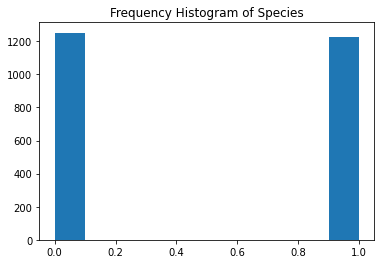

<Figure size 864x864 with 0 Axes>

In [ ]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

Παρουσίαση εικόνων COVID

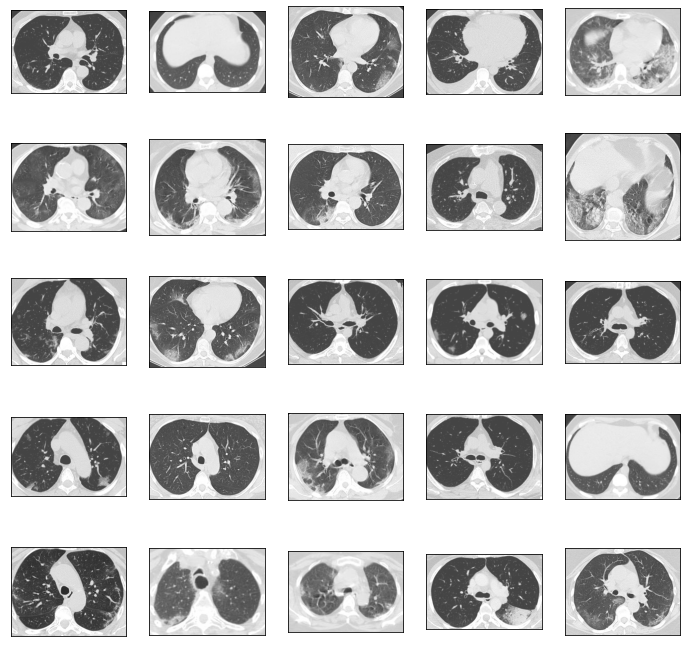

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

Παρουσίαση εικόνων non-COVID

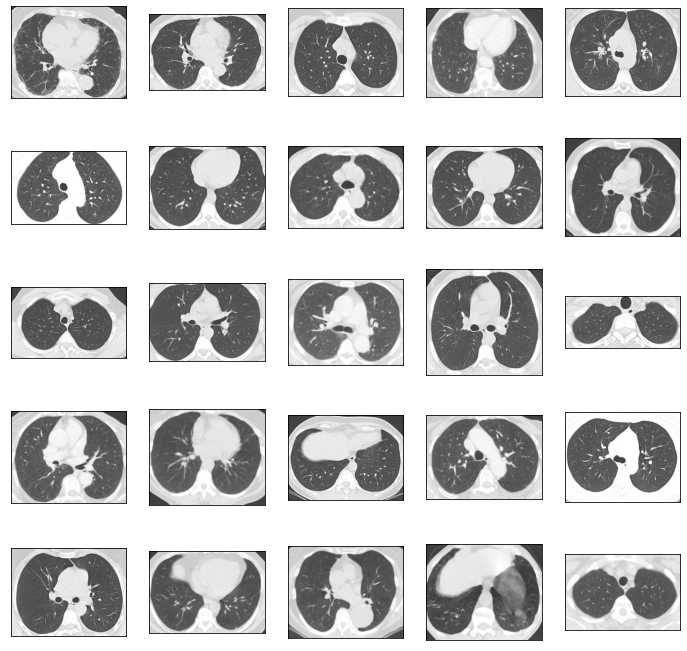

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

Image Read and Resize Function

In [ ]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

Εκπαίδευση εικόνων

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:28, 86.49it/s] 


Train Shape: (2481, 64, 64, 3)


Μετατροπή ετικετών σε κατηγορικές

In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(2481, 2)


Χωρίζουμε το dataset σε train και validation set

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

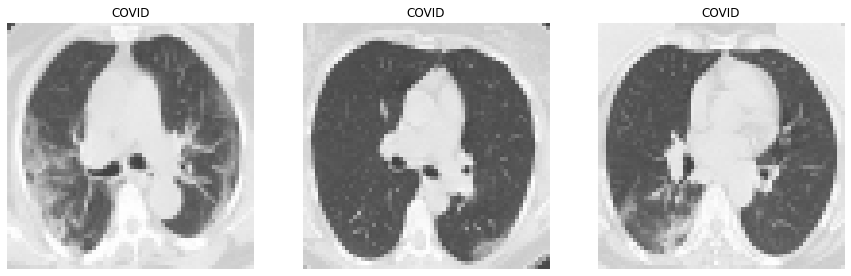

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 50
SIZE=64
N_ch=3

RESNET50

In [ ]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = resnet50(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)


    # model
    model = Model(input,output)

    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

Data Augmentation και εφαρμογή του μοντέλου

In [ ]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


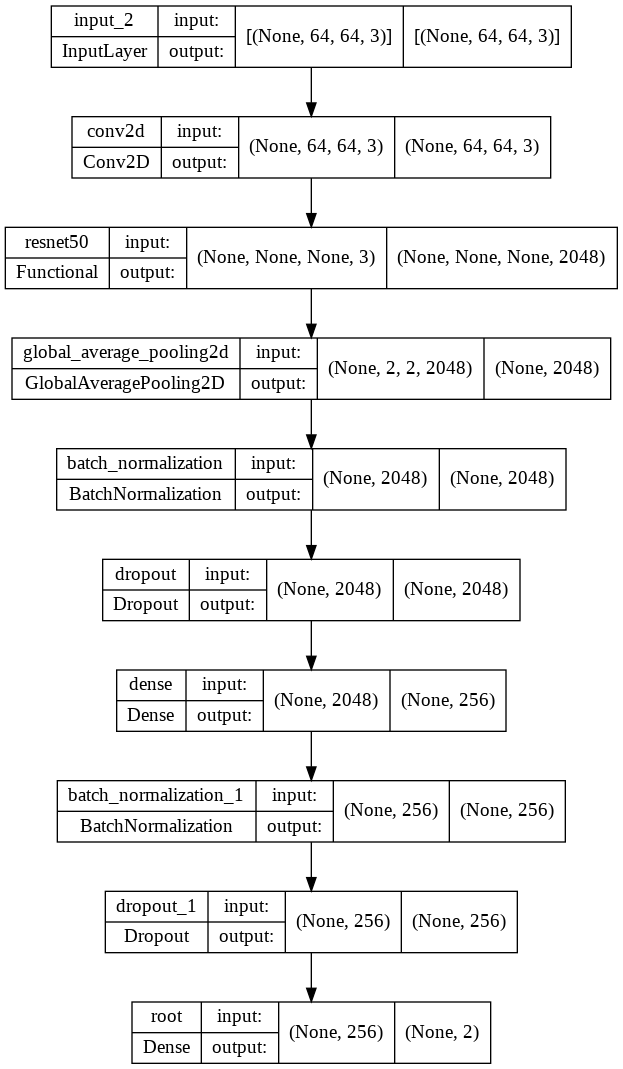

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
# Fits the model on batches with real-time data augmentation
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


31/31 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.5348
Epoch 1: val_loss improved from inf to 1.14536, saving model to model.h5
31/31 [==============================] - 16s 211ms/step - loss: 1.2303 - accuracy: 0.5348 - val_loss: 1.1454 - val_accuracy: 0.5513 - lr: 0.0030
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.9965 - accuracy: 0.5771
Epoch 2: val_loss improved from 1.14536 to 0.98851, saving model to model.h5
31/31 [==============================] - 5s 168ms/step - loss: 0.9965 - accuracy: 0.5771 - val_loss: 0.9885 - val_accuracy: 0.5513 - lr: 0.0030
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.9093 - accuracy: 0.6154
Epoch 3: val_loss did not improve from 0.98851
31/31 [==============================] - 4s 118ms/step - loss: 0.9093 - accuracy: 0.6154 - val_loss: 2.5288 - val_accuracy: 0.5513 - lr: 0.0030
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.8442 - accuracy: 0.6326
Epoch

Accuracy and Loss Curve

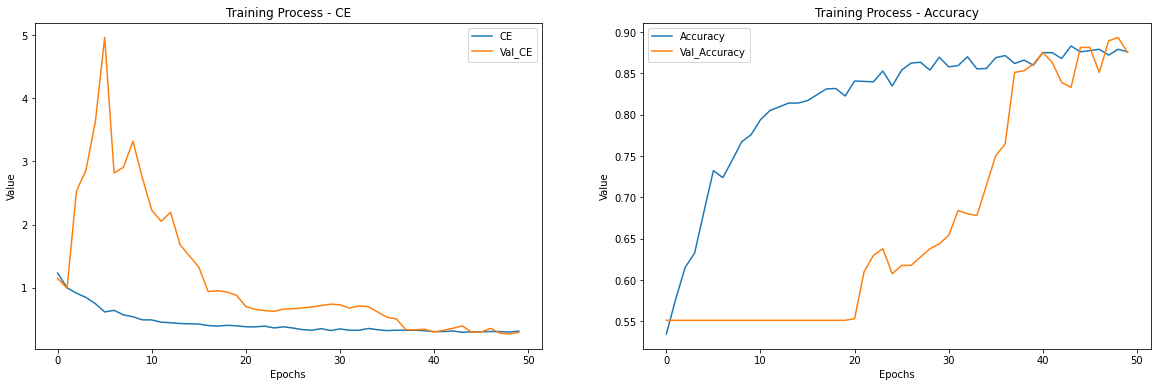

In [ ]:
# Create a graph that will have 2 signatures next to each other
fig, axis = plt.subplots(nrows=1,ncols=2, figsize=(20,6))

#  Creating the first graph (left)
axis[0].plot(history.epoch, history.history['loss']) # creation of Cross Entropy training graph
axis[0].plot(history.epoch, history.history['val_loss']) # creation of Cross Entropy Verification graph
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Value")
axis[0].legend(["CE", "Val_CE"])
axis[0].set_title("Training Process - CE")

# Creating the second graph (right) - Same procedure but for Accuracy
axis[1].plot(history.epoch, history.history['accuracy'])
axis[1].plot(history.epoch, history.history['val_accuracy'])
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Value")
axis[1].legend(["Accuracy", "Val_Accuracy"])
axis[1].set_title("Training Process - Accuracy")
plt.show()

Final Loss and Accuracy

In [ ]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 0s 19ms/step - loss: 0.2886 - accuracy: 0.8753
Final Loss: 0.2886282503604889, Final Accuracy: 0.8752515316009521


Confusion Matrix

Text(0.5, 145.31999999999996, 'Predicted')

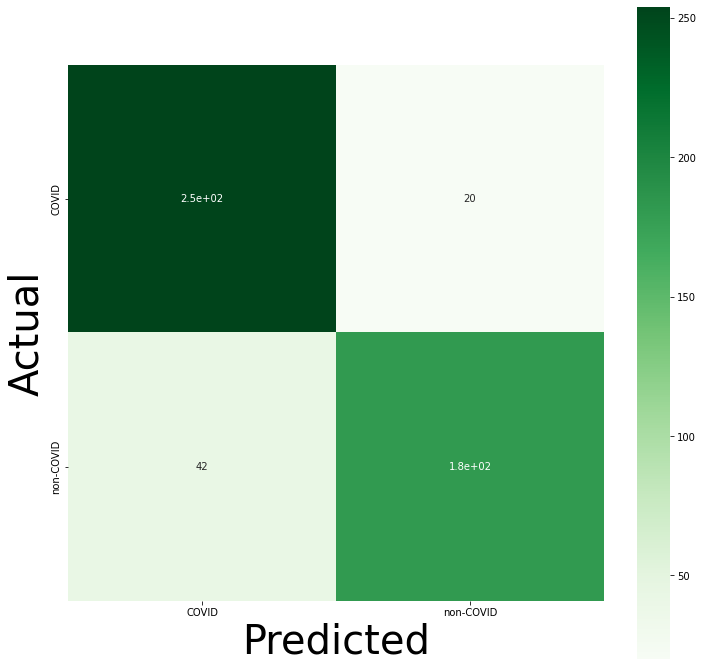

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:


'''FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)'''

TN = cm[0][0]
#print(TN)
FN = cm[1][0]
#print(FN)
TP = cm[1][1]
#print(TP)
FP = cm[0][1]
#print(FP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print(TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP)
print(TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
print(FNR)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print(ACC)

0.8116591928251121
0.927007299270073
0.18834080717488788
0.8752515090543259


ΣΥΜΠΕΡΑΣΜΑΤΑ

Στην παρούσα εργασία, παρουσιάστηκε ένα λεπτομερώς ρυθμισμένο μοντέλο ResNet50 που χρησιμοποιήθηκε για την αποτελεσματική ταξινόμηση του COVID-19 από εικόνες αξονικών τομογραφιών. Στην εργασία επιτυγχάνεται ακρίβεια 87,5%, επίσης παρατηρούμε ότι το sensitivity score είναι 81,1% και το Specificity score είναι 92,7%.

